# Introduction to the ENLYZE Python SDK
---
This guide introduces you to the concepts of the ENLYZE platform and shows you how they are implemented in the Python SDK.
We will use the SDK to query information about different locations and appliances (machines), and ultimately query time series data of one appliance to further analyze and process it. 

In the second half, we will query production runs and OEE KPIs and prepare the data to be exported to Excel or used by Power BI.

All is based on our demo organization, which represents an imaginary company with several locations, exemplary appliances and dummy time series data.

## Installation

The [enlyze-python package](https://github.com/enlyze/enlyze-python) is an open-source package that can be directly installed via pip. The full documentation of the SDK can be found [here](https://enlyze-python.readthedocs.io/en/latest/) and also provides a detailed installation guide for macOS/Linux and Windows.

In short, all you need to do is run the following command in your shell. You can install it globally or in a virtualenv.

```bash
$ pip install enlyze
```

Installing the enlyze package will install all the required dependencies and would be enough to interact with the platform and process the data. But we will explore some more options within this tutorial, so if you want to follow along, you need to install the following additional packages:

    # loading secrets from .env files
    pip install python-dotenv

    # visualization
    pip install matplotlib
    pip install seaborn

    # saving data to excel
    pip install openpyxl

## General imports

In [1]:
%load_ext dotenv
%dotenv ../.env

In [2]:
import os

from datetime import datetime

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
mpl.rc("legend",fontsize=12)
mpl.rc("axes", titlesize=14)

import pandas as pd
# To display large DataFrames
pd.options.display.max_rows = 100

# Set the color schema
import seaborn as sns
sns.set_style("whitegrid")

## Client setup

The only thing you need to interact with the ENLYZE platform is an API token. Reach out to us if you haven't received one already. This token will give you access to all the data of your organization, so please keep it safe! In case you have lost your token or you think it might have been compromised please reach out to us as well.

**Store your secrets and config variables in a special file**  
You don't want to leak your token on Github or any other version control system. One way to do this is to create a `.env` file in your project root folder and store your token and other secrets in it. Make sure to add it to your `.gitignore` file, so it is kept out of version control. Here is an example:

```
# example .env file
ENLYZE_API_TOKEN="XXX"
```

You can then use a package to load these variabels automatically. Here we are using a package called [python-dotenv](https://github.com/theskumar/python-dotenv). 
It loads up all the entries in this file as environment variables so they are accessible with `os.environ.get`/`os.getenv`.

This happend a few cells above with the commands:

```python
%load_ext dotenv
%dotenv ../.env-demo
```

Now, since the token is stored in an environment variable, we can use it to set up our client:

In [3]:
from enlyze import EnlyzeClient

In [4]:
enlyze = EnlyzeClient(os.getenv("ENLYZE_API_TOKEN"))

## Sites, Appliances (Machines), and Variables

These three are the core models to interact with the platform. An organization consists of one or multiple sites, which again hold one or multiple appliances. Each appliance has then a set of variables. A variable represents a process measure of one appliance of which timeseries data is captured and stored in the ENLYZE platform. One appliance can have many variables, whereas one variable is only associated with one appliance.

To get variables, we need to traverse down this tree until we get and select the variables we want, and then use these variables to query their data.

There are different ways how this can be done, but for now, we will simply go from top to bottom.

In [5]:
from enlyze.models import Site, Appliance, Variable

### Sites

A list of all sites can be fetched by using the `get_sites` method:

In [6]:
sites = enlyze.get_sites()
sites

[Site(_id=49, display_name='Platform', address='Maybachstrasse 156'),
 Site(_id=32, display_name='Köln', address='Heliosstrasse 6a'),
 Site(_id=35, display_name='Stuttgart', address='Mahlestrasse 67')]

<div class="alert alert-block alert-info">
<b>Side note:</b> data analysis in Python 🫶 pandas
</div>

If you are new to processing data in Python, you will inevitably come across pandas and pandas DataFrames. [Pandas](https://pandas.pydata.org/docs/index.html) is a great, open-source library providing high-performance, easy-to-use data structures and data analysis tools for the [Python](https://www.python.org/) programming language.

Due to its many advantages for data processing and widespread use in the Python ecosystem, it is already part of the enlyze package and is installed alongside as a requirement.

Especially in [Jupyter Notebooks](https://jupyterlab.readthedocs.io/en/stable/getting_started/overview.html) it makes working with and visualizing data straightforward. You will notice that models (Site, Appliances, Variables etc.) have different attributes and are often returned in a list. For a few models and properties, printing the list in its raw form is still sufficient. But we soon reach the limits, and it becomes confusing and unmanageable. For this, we have this small utility function `models_to_dataframe` that takes a list of models and returns them as a DataFrame. This makes it a lot easier to explore data.

In [7]:
def models_to_dataframe(models: list):
    """Convert a list of enlyze models to a DataFrame"""
    return pd.DataFrame([m.__dict__ for m in models])
    

In [8]:
models_to_dataframe(sites)

,_id,display_name,address
0,49,Platform,Maybachstrasse 156
1,32,Köln,Heliosstrasse 6a
2,35,Stuttgart,Mahlestrasse 67


We will pick a site by selecting an element from the list.

In [9]:
site = sites[1]
site

Site(_id=32, display_name='Köln', address='Heliosstrasse 6a')

### Appliances

We can get a list of all appliances by using the `get_appliances` method. Optionally, we can pass a site to the function to filter by it.

In [10]:
models_to_dataframe(enlyze.get_appliances())

,uuid,display_name,genesis_date,site
0,fafdee59-933b-40bc-b3ce-c59c7363e358,PLC Rack,2023-03-21,"Site(_id=49, display_name='Platform', address=..."
1,22a71d1e-8262-4c27-b5fb-66598027936a,W&H Varex,2022-03-18,"Site(_id=32, display_name='Köln', address='Hel..."
2,cc0d2dcb-564b-48cd-a342-71765a536058,Macchi,2021-01-15,"Site(_id=32, display_name='Köln', address='Hel..."
3,141e0927-62b3-4e76-8398-ad82d20f397f,Kiefel,2020-08-26,"Site(_id=32, display_name='Köln', address='Hel..."
4,f5c0b9d4-e89e-43ad-b81c-16bd5cbe3646,Reifenhäuser,2021-01-21,"Site(_id=35, display_name='Stuttgart', address..."
5,0eba5355-1dc2-49d5-b539-2ca191dadb76,Alpine,2021-01-15,"Site(_id=35, display_name='Stuttgart', address..."


Filtering by site will only return the respective appliances:

In [11]:
cologne_appliances = enlyze.get_appliances(site=site)
models_to_dataframe(cologne_appliances)

,uuid,display_name,genesis_date,site
0,22a71d1e-8262-4c27-b5fb-66598027936a,W&H Varex,2022-03-18,"Site(_id=32, display_name='Köln', address='Hel..."
1,cc0d2dcb-564b-48cd-a342-71765a536058,Macchi,2021-01-15,"Site(_id=32, display_name='Köln', address='Hel..."
2,141e0927-62b3-4e76-8398-ad82d20f397f,Kiefel,2020-08-26,"Site(_id=32, display_name='Köln', address='Hel..."


**Selecting an appliance by UUID**

A more reliable way to select an appliance from the list is filtering by `UUID`. Attributes like the name may change over time, but the assigned `UUID` will stay unchanged.

In [12]:
from uuid import UUID

In [13]:
APPLIANCE_UUID = UUID("22a71d1e-8262-4c27-b5fb-66598027936a")

We can create a function, that returns the appliance, if it matches the UUID:

In [14]:
def get_appliance_by_uuid(uuid: UUID, appliances: list[Appliance]):
    for appliance in appliances:
        if appliance.uuid == uuid:
            return appliance
            

In [15]:
get_appliance_by_uuid(APPLIANCE_UUID, cologne_appliances)

Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-66598027936a'), display_name='W&H Varex', genesis_date=datetime.date(2022, 3, 18), site=Site(_id=32, display_name='Köln', address='Heliosstrasse 6a'))

Or we can use Python's built-in `filter()` method, more compact but less readable:

In [16]:
results = filter(lambda a: a.uuid == APPLIANCE_UUID, cologne_appliances)
appliance = next(results)

appliance

Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-66598027936a'), display_name='W&H Varex', genesis_date=datetime.date(2022, 3, 18), site=Site(_id=32, display_name='Köln', address='Heliosstrasse 6a'))

### Variables

The last step we need to make is getting the variables for an appliance. We use the `get_variables`method, which always requires the specification of an appliance.

In [17]:
variables = enlyze.get_variables(appliance)

In [18]:
variables_df = models_to_dataframe(variables)

In [19]:
variables_df.head()

,uuid,display_name,unit,data_type,appliance
0,03e13e36-3a5f-4d9b-babf-58da68cde23f,Extruder C Schneckenumdrehung,1/min,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
1,063e9d4a-1687-4d7e-95e3-fdd56be1c68c,Extruder A Schmelzedruck,bar,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
2,07420ec1-76da-4288-b9ee-b14891005144,Extruder C Schmelzedruck,bar,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
3,094853e6-702d-43ab-a612-15ea0dfc90c3,Extruder I Schneckenumdrehung,1/min,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
4,0b8af028-7bea-4b71-8719-48bb8c57505d,Anzahl Messungen,n,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...


In [20]:
variables_df = (
    variables_df
    .sort_values(by="display_name")
    .reset_index(drop=True)
)

In [21]:
variables_df.head()

,uuid,display_name,unit,data_type,appliance
0,84802f7e-96a5-4e81-a61d-2c9c133bc58c,2-Sigma,%,VariableDataType.FLOAT,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
1,163fb0cc-0e24-4092-8873-775ea9daccad,Abzugsgeschwindigkeit,m/min,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
2,0b8af028-7bea-4b71-8719-48bb8c57505d,Anzahl Messungen,n,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
3,f0e3d6cc-d302-4b0f-a660-8217f1b5d1ea,Durchsatz,kg/h,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
4,378f5c4f-958e-4d72-98dc-88b6ac700b4b,Extruder A Durchsatz,kg/h,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...


We will select variables of the Extruder A and all melt pressures for the next steps:

In [22]:
extruder_a_variables_df = (
    variables_df.loc[
        variables_df["display_name"].str.contains("Extruder A")
    ]
    .copy()
)

# a filtered copy of the DataFrame
extruder_a_variables_df

,uuid,display_name,unit,data_type,appliance
4,378f5c4f-958e-4d72-98dc-88b6ac700b4b,Extruder A Durchsatz,kg/h,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
5,3bbcd24b-684c-49fc-b3d4-8e77f9f13a07,Extruder A Folienstärke,µm,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
6,dab58100-7bf2-4a37-ba9c-7130897051a8,Extruder A Förderrate,kg/U/min,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
7,063e9d4a-1687-4d7e-95e3-fdd56be1c68c,Extruder A Schmelzedruck,bar,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
8,5c5eb4a7-a6ed-47ff-a971-722e6334801b,Extruder A Schmelzetemperatur,°C,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
9,c1a6fde4-d5e8-4b0f-a064-ae961d2bf962,Extruder A Schneckenumdrehung,1/min,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...


In [23]:
melt_pressures_df = (
    variables_df.loc[
        variables_df["display_name"].str.contains(r"Extruder [A-B]")
    ].copy()
)

melt_pressures_df

,uuid,display_name,unit,data_type,appliance
4,378f5c4f-958e-4d72-98dc-88b6ac700b4b,Extruder A Durchsatz,kg/h,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
5,3bbcd24b-684c-49fc-b3d4-8e77f9f13a07,Extruder A Folienstärke,µm,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
6,dab58100-7bf2-4a37-ba9c-7130897051a8,Extruder A Förderrate,kg/U/min,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
7,063e9d4a-1687-4d7e-95e3-fdd56be1c68c,Extruder A Schmelzedruck,bar,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
8,5c5eb4a7-a6ed-47ff-a971-722e6334801b,Extruder A Schmelzetemperatur,°C,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
9,c1a6fde4-d5e8-4b0f-a064-ae961d2bf962,Extruder A Schneckenumdrehung,1/min,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
10,c9709564-395c-403e-be34-96bb2c41551c,Extruder B Durchsatz,kg/h,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
11,8057cb67-e711-4b43-93cc-0342ec7dae44,Extruder B Folienstärke,µm,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
12,1a07c75f-6c00-4d21-8512-8578008928fa,Extruder B Förderrate,kg/U/min,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...
13,aa62c591-bd89-4423-8ea4-d973290f0dad,Extruder B Schmelzedruck,bar,VariableDataType.INTEGER,Appliance(uuid=UUID('22a71d1e-8262-4c27-b5fb-6...


The resulting DataFrames `extruder_a_variables_df` and `melt_pressures_df` are a copy of the filtered `variables_df` DataFrame. In this case, creating a copy is not necessary because we are not further changing the data, but it's good practice when you work with DataFrames.

If you don't use `.copy()`, the assigned variable will only hold a view of the original DataFrame and changing it would also change the data in the original DataFrame. This can cause some unexpected behaviour and difficult to trace errors, so usually pandas will throw a `SettingWithCopyWarning` error if you do so.

<div class="alert alert-block alert-danger">
<b>SettingWithCopyWarning:</b> A value is trying to be set on a copy of a slice from a DataFrame.
</div>

Check out the [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html) for more details.

## Time series data

Now that we have selected the variables we are interested in, we can use them to get time series data.

Pandas built-in filtering allows to quickly select the variables we want, but `get_timeseries` expects a list of `enlyze.models.Variable`'s.

In [24]:
extruder_a_variables = []

# iterate over all variables
for variable in variables:
    if variable.uuid in extruder_a_variables_df["uuid"].tolist():
        # if a uuid is in the uuid-column of the DataFrame
        # add the variable to the list
        extruder_a_variables.append(variable)
        

In [25]:
melt_pressures = []

for variable in variables:
    if variable.uuid in melt_pressures_df["uuid"].tolist():
        melt_pressures.append(variable)
        

### For small periods and quick explorations - get_timeseries()

The `get_timeseries` expects a start and end time, ideally with a timezone specified, and a list of variables.

It then returns a `TimeseriesData` object, from which the data can be retrieved as a pandas DataFrame or dictionary (records). By default, the column names will be set to the `variable_uuids` but if `use_display_names` is set to True, it will return the DataFrame with human-readable names.

<div class="alert alert-block alert-info">
<b>Note:</b> Display names are not guaranteed to be unique for an appliance.
</div>

If two or more variables with the same display name exist, there will be multiple columns with the same name. This can lead to unexpected behavior in later steps. However, display names can be adjusted in the app at any time, thus solving this problem.


In [26]:
start = datetime.fromisoformat("2022-05-17 05:00:00+01:00")

end = datetime.fromisoformat("2022-05-28 18:00:00+01:00")

ts_data = enlyze.get_timeseries(start=start, end=end, variables=melt_pressures)

In [27]:
data = ts_data.to_dataframe(use_display_names=True)

In [28]:
data.head()

,Extruder A Schmelzedruck,Extruder B Förderrate,Extruder A Durchsatz,Extruder A Folienstärke,Extruder A Schmelzetemperatur,Extruder B Folienstärke,Extruder B Schneckenumdrehung,Extruder B Schmelzedruck,Extruder A Schneckenumdrehung,Extruder B Durchsatz,Extruder A Förderrate,Extruder B Schmelzetemperatur
time,,,,,,,,,,,,
2022-05-17 04:00:00+00:00,387.0,127.0,50.0,2.0,211.0,3.0,71.0,502.0,67.0,90.0,74.0,210.0
2022-05-17 04:00:10+00:00,388.0,127.0,50.0,2.0,211.0,3.0,71.0,502.0,67.0,90.0,74.0,210.0
2022-05-17 04:00:20+00:00,388.0,127.0,50.0,2.0,211.0,3.0,71.0,502.0,67.0,90.0,74.0,210.0
2022-05-17 04:00:30+00:00,388.0,127.0,50.0,2.0,211.0,3.0,71.0,502.0,67.0,90.0,74.0,210.0
2022-05-17 04:00:40+00:00,388.0,127.0,50.0,2.0,211.0,3.0,71.0,500.0,67.0,90.0,74.0,210.0


Note that the index of the DataFrame is the time-column and the timezone is always UTC, regardless of the timezone specified in the request.

Using the `reset_index()` method will use the index as a column and set a default index instead:

In [29]:
data = data.reset_index()
data.head()

,time,Extruder A Schmelzedruck,Extruder B Förderrate,Extruder A Durchsatz,Extruder A Folienstärke,Extruder A Schmelzetemperatur,Extruder B Folienstärke,Extruder B Schneckenumdrehung,Extruder B Schmelzedruck,Extruder A Schneckenumdrehung,Extruder B Durchsatz,Extruder A Förderrate,Extruder B Schmelzetemperatur
0,2022-05-17 04:00:00+00:00,387.0,127.0,50.0,2.0,211.0,3.0,71.0,502.0,67.0,90.0,74.0,210.0
1,2022-05-17 04:00:10+00:00,388.0,127.0,50.0,2.0,211.0,3.0,71.0,502.0,67.0,90.0,74.0,210.0
2,2022-05-17 04:00:20+00:00,388.0,127.0,50.0,2.0,211.0,3.0,71.0,502.0,67.0,90.0,74.0,210.0
3,2022-05-17 04:00:30+00:00,388.0,127.0,50.0,2.0,211.0,3.0,71.0,502.0,67.0,90.0,74.0,210.0
4,2022-05-17 04:00:40+00:00,388.0,127.0,50.0,2.0,211.0,3.0,71.0,500.0,67.0,90.0,74.0,210.0


To convert the timezone back to the local timezone you can use pandas Datetime functionality:

In [30]:
data["time_local"] = data["time"].dt.tz_convert("Europe/Berlin")
data[["time","time_local", "Extruder A Schmelzedruck"]]

,time,time_local,Extruder A Schmelzedruck
0,2022-05-17 04:00:00+00:00,2022-05-17 06:00:00+02:00,387.0
1,2022-05-17 04:00:10+00:00,2022-05-17 06:00:10+02:00,388.0
2,2022-05-17 04:00:20+00:00,2022-05-17 06:00:20+02:00,388.0
3,2022-05-17 04:00:30+00:00,2022-05-17 06:00:30+02:00,388.0
4,2022-05-17 04:00:40+00:00,2022-05-17 06:00:40+02:00,388.0
...,...,...,...
99699,2022-05-28 16:59:10+00:00,2022-05-28 18:59:10+02:00,338.0
99700,2022-05-28 16:59:20+00:00,2022-05-28 18:59:20+02:00,338.0
99701,2022-05-28 16:59:30+00:00,2022-05-28 18:59:30+02:00,338.0
99702,2022-05-28 16:59:40+00:00,2022-05-28 18:59:40+02:00,338.0


### For large periods and more fine-grained control - get_timeseries_with_resampling()

The `get_timeseries` method returns the time series in the currently highest resolution (10 seconds). For a long period and many variables, this quickly results in a large amount of data. Due to the size of the data, there might be a noticeable delay in receiving the results, and in some cases, it may even cause a request timeout.

The `get_timeseries_with_resampling` method allows for a higher control over the way in which the data is retrieved. By specifying a resampling method and a resampling interval, the amount of data can be adjusted for the use case. Resampling happens on the server-side and thus reduces the payload.


A separate resampling method must be specified for each variable. This is necessary because not every resampling method is available for every data type. For example, categorical data types such as strings can only be aggregated with 'first', 'last' or 'count'. You can find all available resampling methods [in our documentation](https://enlyze-python.readthedocs.io/en/latest/models.html#enlyze.models.ResamplingMethod).

In [31]:
from enlyze.models import ResamplingMethod

In [32]:
# pandas has some very handy Timestamp and Timedelta functionalities that are worth checking out
end = pd.Timestamp.utcnow()
start = end - pd.Timedelta(weeks=2)


<div class="alert alert-block alert-info">
<b>Tip:</b> You can access the Docstring of a function in Jupyter Notebooks, if you call it with a question mark right after the name, for example: `enlyze.get_timeseries_with_resampling?`
</div>

For our example, we will use the same resampling method for all variables and a `resampling_interval` of 10 minutes

In [33]:
ts_data_resampled = enlyze.get_timeseries_with_resampling(
    start=start,
    end=end,
    variables={v: ResamplingMethod("avg") for v in melt_pressures},
    resampling_interval=600
)

data_resampled = ts_data_resampled.to_dataframe(use_display_names=True)

In [34]:
data_resampled.head()

,Extruder A Schmelzedruck,Extruder B Förderrate,Extruder A Durchsatz,Extruder A Folienstärke,Extruder A Schmelzetemperatur,Extruder B Folienstärke,Extruder B Schneckenumdrehung,Extruder B Schmelzedruck,Extruder A Schneckenumdrehung,Extruder B Durchsatz,Extruder A Förderrate,Extruder B Schmelzetemperatur
time,,,,,,,,,,,,
2023-11-22 15:40:00+00:00,-10.833333,0.0,0.0,0.0,18.0,0.0,0.0,-6.944444,0.0,0.0,0.0,18.0
2023-11-22 15:50:00+00:00,-10.883333,0.0,0.0,0.0,18.0,0.0,0.0,-7.016667,0.0,0.0,0.0,18.0
2023-11-22 16:00:00+00:00,-10.933333,0.0,0.0,0.0,18.0,0.0,0.0,-7.000000,0.0,0.0,0.0,18.0
2023-11-22 16:10:00+00:00,-10.950000,0.0,0.0,0.0,18.0,0.0,0.0,-7.033333,0.0,0.0,0.0,18.0
2023-11-22 16:20:00+00:00,-10.933333,0.0,0.0,0.0,18.0,0.0,0.0,-7.000000,0.0,0.0,0.0,18.0


### Data preparation and exploration

Data preparation and exploration is a bigger topic that will be covered in later tutorials, but here are a few examples of how to get started. 

In [35]:
# quick step to sort the columns alphabetically
data_resampled = data_resampled[sorted(data_resampled.columns)]

In [36]:
# reset index and convert time to local timezone
data_resampled = data_resampled.reset_index()
data_resampled["time"] = data_resampled["time"].dt.tz_convert("Europe/Berlin")

#### Simple plot

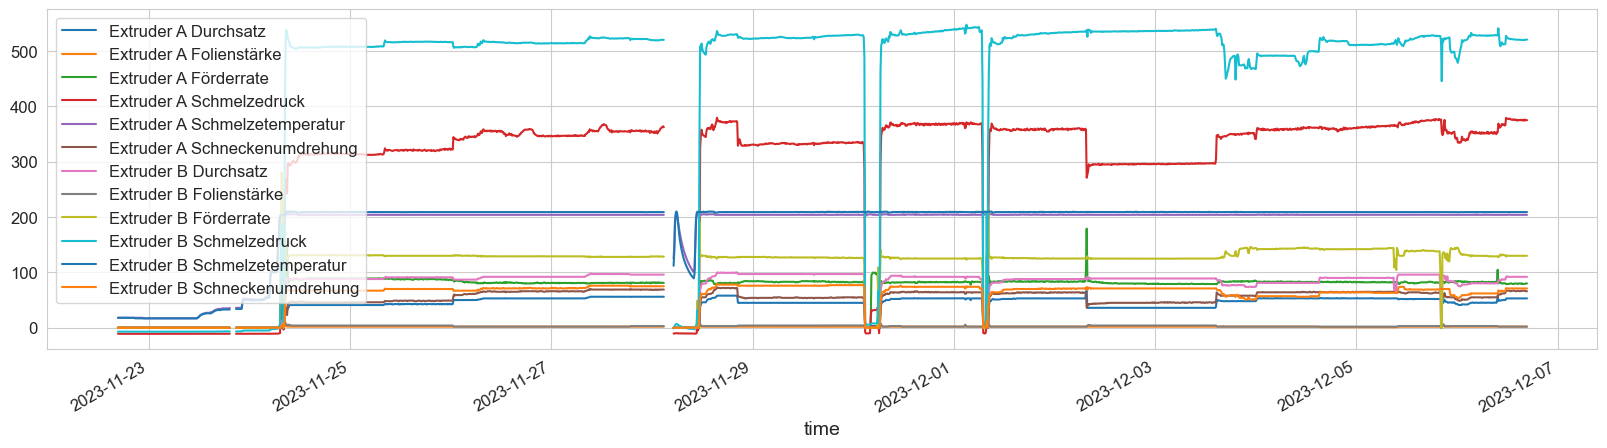

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
data_resampled.plot(x="time", ax=ax);

#### Subplots

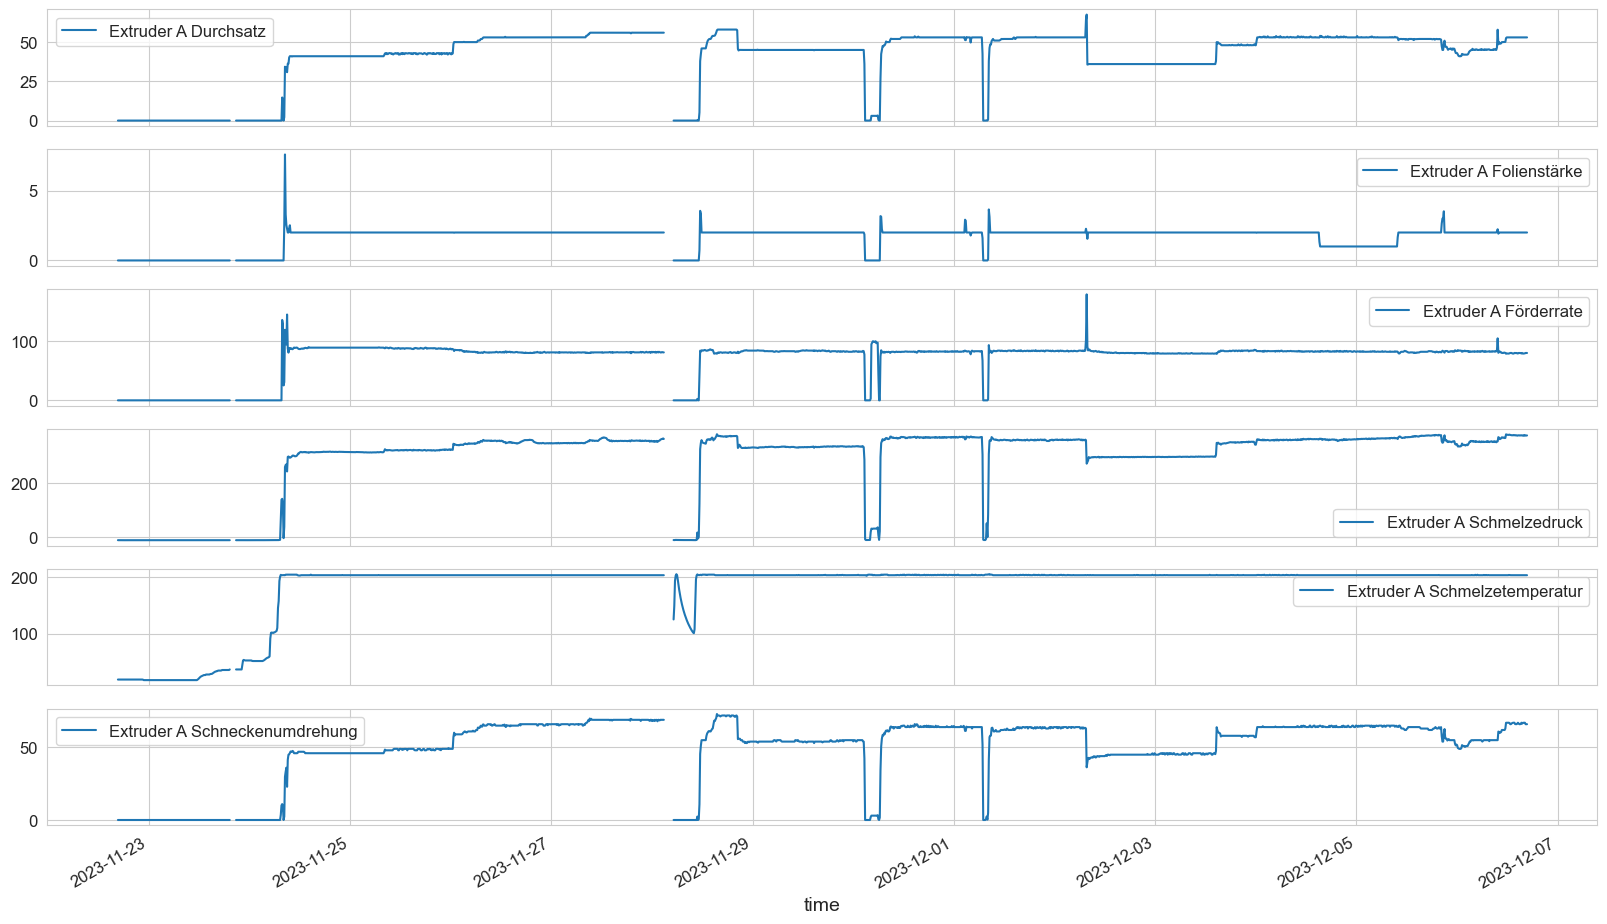

In [38]:
y_values = [col for col in data_resampled.columns if "Extruder A" in col]

rows = len(y_values) 
cols = 1

fig, axes = plt.subplots(rows, cols, figsize=(20, 2*rows), sharex=True)

for i, col in enumerate(y_values):
    data_resampled.plot(x="time", y=col, ax=axes[i])

#### Pairplots

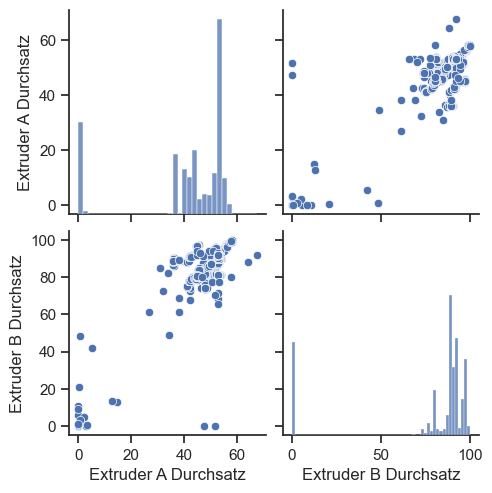

In [39]:
sns.set_theme(style="ticks")

columns = [col for col in data_resampled.columns if "Durchsatz" in col]

sns.pairplot(data_resampled[columns]);

## Production runs
If your production runs are integrated to the ENLYZE Platform, you can also use the `EnlyzeClient` to query them, alongside the calculated OEE metrics per run.
You can fetch all runs at once or use filters to fetch runs specific product, orders, appliances or within a certain time range.

We will use our previously selected appliance from above to filter the runs. Since this is a demo account, the KPIs are not meaningful, but this should give you a good idea of the data and what is possible.

In [40]:
runs = enlyze.get_production_runs(appliance=appliance)

Unlike the time series data or the appliances, the runs are returned as a `enlyze.models.ProductionRuns` model. This model as a `to_dataframe` method, which conveniently converts the runs into a pandas DataFrame for us.

In [41]:
type(runs)

enlyze.models.ProductionRuns

In [42]:
runs_df = runs.to_dataframe()
runs_df.head()

,uuid,average_throughput,production_order,start,end,quantity_total,quantity_yield,availability,performance,quality,...,quantity_yield.value,availability.score,availability.time_loss,performance.score,performance.time_loss,quality.score,quality.time_loss,productivity.score,productivity.time_loss,quantity_scrap
0,99245861-840e-42f6-9888-494339e88eb4,NaN,FA-0A5A-1,2022-03-18 00:13:08+00:00,2022-03-18 01:16:09+00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
1,3756a10c-b564-42bb-83f1-5f5d6aba6d30,230.552952,FA-0A5A-2,2022-03-18 01:16:19+00:00,2022-03-18 18:41:55+00:00,NaN,NaN,NaN,NaN,NaN,...,3236.319444,1.000000,0 days 00:00:00,0.384255,0 days 08:38:36,0.805502,0 days 03:23:22,0.309518,0 days 12:01:58,NaN
2,1366390c-a1c5-4fc3-a4f5-74ade57e118d,459.256323,FA-0A5A-3,2022-03-18 18:42:01+00:00,2022-03-19 06:38:57+00:00,NaN,NaN,NaN,NaN,NaN,...,5107.452778,1.000000,0 days 00:00:00,0.907621,0 days 01:01:38,0.930726,0 days 00:49:39,0.844746,0 days 01:51:17,NaN
3,98de1da6-69c5-4afa-bd0f-1c1f52440a8b,486.231561,FA-0A5A-4,2022-03-19 06:39:04+00:00,2022-03-20 22:34:24+00:00,NaN,NaN,NaN,NaN,NaN,...,18144.694444,1.000000,0 days 00:00:00,0.809038,0 days 07:07:34,0.934742,0 days 02:36:18,0.756241,0 days 09:43:52,NaN
4,b9efc595-ceb7-424f-99b0-f47d2d588cfe,499.188133,FA-0A5A-5,2022-03-20 22:34:30+00:00,2022-03-22 15:33:14+00:00,NaN,NaN,NaN,NaN,NaN,...,19749.269444,0.999187,0 days 00:01:59,0.818341,0 days 07:10:52,0.965443,0 days 01:24:53,0.789419,0 days 08:37:44,NaN


## Exporting Data

Pandas DataFrames can be exported to many different data formats. For a full list of supported methods, you can check out the [IO tools](https://pandas.pydata.org/docs/user_guide/io.html#io) section of the pandas documentation or the [Importing and exporting data](https://pandas.pydata.org/docs/user_guide/10min.html#importing-and-exporting-data) part of the **10 minutes to pandas** guide.

### To CSV

Probably the most used method and quite straightforward:

In [ ]:
# path to directory with filename
runs_df.to_csv("./filename.csv")

If a different separator or decimal character is required, they can be specified in the export method.

A full, detailed list of all the options can be found [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html). Specifying the separator and the decimal character is especially useful when opening the file in German Excel.

In [ ]:
runs_df.to_csv("./filename.csv", sep=";", decimal=",", index=False)

### Excel and Power BI

<div class="alert alert-block alert-info">
<b>Note:</b> Excel and Power BI don't support all Python data types.
</div>

There is an option to directly save the data as an Excel file. This requires the additional `openpyxl` package, which can be easily installed via pip:

    pip install openpyxl

If you use the [Python Scripts](https://learn.microsoft.com/de-de/power-bi/connect-data/desktop-python-scripts) data connector in Power BI to load data into Power BI, you can directly use the API but need to convert the unsupported data types before returning the DataFrame.

To avoid errors or false data representations, some Python data types need to be converted to supported types. Excel and Power BI don't support timestamps with time zone information and timedeltas. You can use the `DataFrame.info()` method, to see which data types your DataFrame contains.

In [43]:
runs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   uuid                         227 non-null    object             
 1   average_throughput           217 non-null    float64            
 2   production_order             227 non-null    object             
 3   start                        227 non-null    datetime64[ns, UTC]
 4   end                          226 non-null    datetime64[ns, UTC]
 5   quantity_total               0 non-null      float64            
 6   quantity_yield               0 non-null      float64            
 7   availability                 0 non-null      float64            
 8   performance                  0 non-null      float64            
 9   quality                      0 non-null      float64            
 10  productivity                 0 non-null      float

**Removing timezone information:**

To remove the time zone information, we will first convert the timestamp to the desired time zone (if it's UTC, than this can be skipped) and then remove the timezone information, making them timezone naive.

In [44]:
# convert timestamps to local time zone
runs_df["start"] = runs_df["start"].dt.tz_convert("Europe/Berlin")
runs_df["end"] = runs_df["end"].dt.tz_convert("Europe/Berlin")

# remove time zone information
runs_df["start"] = runs_df["start"].dt.tz_localize(None)
runs_df["end"] = runs_df["end"].dt.tz_localize(None)

**Convert timedeltas into total_seconds:**

The timedelta datatype is best transformed into the total seconds equivalent of the duration. From there, it can be converted to other proprietary data types.

In [45]:
runs_df["availability.time_loss"] = runs_df["availability.time_loss"].dt.total_seconds()
runs_df["performance.time_loss"] = runs_df["performance.time_loss"].dt.total_seconds()
runs_df["quality.time_loss"] = runs_df["quality.time_loss"].dt.total_seconds()
runs_df["productivity.time_loss"] = runs_df["productivity.time_loss"].dt.total_seconds()

In [46]:
runs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   uuid                         227 non-null    object        
 1   average_throughput           217 non-null    float64       
 2   production_order             227 non-null    object        
 3   start                        227 non-null    datetime64[ns]
 4   end                          226 non-null    datetime64[ns]
 5   quantity_total               0 non-null      float64       
 6   quantity_yield               0 non-null      float64       
 7   availability                 0 non-null      float64       
 8   performance                  0 non-null      float64       
 9   quality                      0 non-null      float64       
 10  productivity                 0 non-null      float64       
 11  appliance.uuid               227 non-null    

With the necessary data transformations done, the DataFrame can now be saved as an Excel file or is ready to be returned back to Power BI

In [ ]:
runs_df.to_excel("./filename.xlsx")

🎉 This is it for now. Thank you for reading, and please [reach out to us](<mailto:support@enlyze.com>) if you have questions or would like us to cover a certain topic.  
Best  
Clemens